In [1]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pysam
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd
import pyranges as pr
from itertools import repeat
import pyBigWig
from collections import Counter

In [3]:
# get last pa sites
# get single polya site gene

last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


# get gene model

gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])

In [4]:
# get protein-coding gene

protein_coding_bed = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11_protein_coding.201606.bed'
protein_coding = pr.read_bed(protein_coding_bed, as_df=True)

protein_coding_gene = set(protein_coding['Name'].map(lambda x: x.split('.')[0]))

In [6]:
%store -r output_res

all_gene = set(output_res['gene_id'])

In [7]:
infile = '/public/home/mowp/db/Arabidopsis_thaliana/intergenic_region/araport11.distance_to_downstream_gene.bed'
distance_to_downstream = pr.read_bed(infile, as_df=True)

distance_to_downstream['upstream'] = distance_to_downstream['Name'].map(lambda x: x.split('_')[0])
distance_to_downstream['downstream'] = distance_to_downstream['Name'].map(lambda x: x.split('_')[1])

same_strand_gene = set(distance_to_downstream.query('Score == 1')['upstream'])
different_strand_gene = set(distance_to_downstream.query('Score == 0')['upstream'])

In [8]:
%store -r trna_read_through_len

In [10]:
%store -r cb_pool_read_through_len                

In [11]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        # 获取基因PAS
        return last_pa.at[gene_id, 'End']
    
    elif site_type == 'TTS':
        return int(cb_pool_read_through_len.query('gene_id == @gene_id')['tts'])
#         return int(trna_read_through_len.query('gene_id == @gene_id')['tts'])
    
    elif site_type == 'tRNA':
        _, _, _, pas, tts, strand, *_, start, end, _, _, _ = trna_read_through_len.query('gene_id == @gene_id').values[0]
        if strand == '+':
            return start+1
        else:
            return end
        
    elif site_type == 'downstream':
        try:
            downstream_gene = distance_to_downstream.query('upstream == @gene_id')['downstream'].values[0]
            start = distance_to_downstream.query('upstream == @gene_id')['Start'].values[0]

            values = gene_model.loc[downstream_gene, :].values
            if abs(values[1]-start) < abs(values[2]-start):
                return values[1]+1
            else:
                return values[2]
        except IndexError:
            return None
                                      
    else:
        raise KeyError

In [12]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_bam_cov(infile, gene_id, site_type, before, after):
    '''
    计算基因(加上上下游)区域覆盖度的频数
    site_type = 'PAS' or 'TTS'
    '''
    chrom, *_, strand = gene_model.loc[gene_id]
    strand_boo = STRAND_TO_BOOL[strand]
    if chrom in {'Pt', 'Mt'}:
        return None
    
    n = 0
    cov_list = []
    read_set = set()

    target_site = get_target_site(site_type, gene_id)
    cov = np.zeros(before+after)
    
    if target_site is None:
        return

    if strand == '+':
        start = target_site-before
        end = target_site+after
    else:
        start = target_site-after
        end = target_site+before
    
    if start < 0:
        return
    
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            # 判断是否跟基因是同个方向，针对于链特异文库
            read_strand = read.is_reverse
            if strand_boo is not read_strand:
                continue
            
            read_gene_id = read.get_tag('gi')
            if read_gene_id not in {gene_id, 'None'}:
                continue
                
            if strand == '+':
                read_five_end = read.reference_start
                read_three_end = read.reference_end
                cov_start = read_five_end-start if read_five_end-start >= 0 else 0
                cov_end = read_three_end-start if read_three_end-start <= before+after else end-start
            else:
                read_five_end = read.reference_end
                read_three_end = read.reference_start
                cov_start = end-read_five_end if end-read_five_end >= 0 else 0
                cov_end = end-read_three_end if end-read_three_end <= before+after else end-start

            cov[cov_start: cov_end] += 1
            
            if read.query_name not in read_set:
                n += 1
                read_set.add(read.query_name)
    
    if n >= 15:
        return cov, n, gene_id


def get_bam_meta_result(infile, gene_list, site_type='PAS', before=100, after=100, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(get_bam_cov, repeat(infile), gene_list, repeat(site_type), repeat(before), repeat(after), chunksize=chunksize)
    
    cov = None
    n = 0
    for res in results:
        if res is not None:
            if cov is None:
                cov = np.zeros(len(res[0]))
                
            cov += res[0]/res[1]
            n += 1
            # cov += res[0]
            # n += res[1]
    
    return cov, n


In [15]:
# 同一链上面，termination window end到下游tRNA的距离
%store -r same_strand_distance
# 不同链上面，termination window end到下游tRNA的距离
%store -r diff_strand_distance

In [16]:
# 同一条链上，下游紧密挨着非tRNA基因的基因
%store -r downstream_with_other_gene

# tRNA in different strand

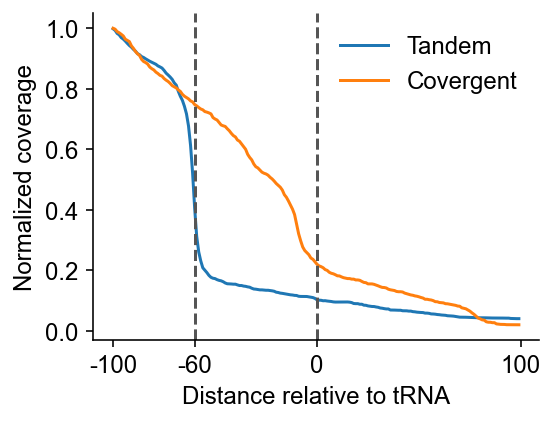

In [104]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

plt.figure(figsize=(4, 3))

gene_list = set(same_strand_distance.query('distance > 0')['gene_id'])
col_tts_cov, col_n = get_bam_meta_result(infile, gene_list, site_type='tRNA', threads=2)
plt.plot(col_tts_cov/col_n, label='Tandem')

gene_list = set(diff_strand_distance.query('distance > 0')['gene_id'])
col_tts_cov, col_n = get_bam_meta_result(infile, gene_list, site_type='tRNA', threads=2)
plt.plot(col_tts_cov/col_n, label='Covergent')

xticks = np.array([0, 40, 100, 200])
plt.xticks(xticks, xticks-100)
plt.axvline(100, ls='--', color='#555555')
plt.axvline(40, ls='--', color='#555555')
# plt.axvline(90, ls='--', color='#555555')
plt.legend(frameon=False)
plt.xlabel('Distance relative to tRNA')
plt.ylabel('Normalized coverage')

sns.despine(top=True, right=True)

# compare with non-tRNA

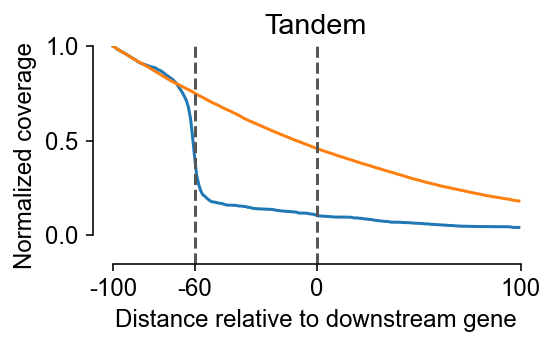

In [259]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

plt.figure(figsize=(4, 2))

gene_list = set(same_strand_distance.query('distance > 0')['gene_id'])
col_cov, col_n = get_bam_meta_result(infile, gene_list, site_type='tRNA', threads=2)
plt.plot(col_cov/col_n, label='tRNA\ndownstream')

gene_list = set(diff_strand_distance.query('distance > 0')['gene_id'])
col_cov, col_n = get_bam_meta_result(infile, downstream_with_other_gene&same_strand_gene, site_type='downstream', threads=64)
plt.plot(col_cov/col_n, label='non-tRNA\ndownstream')

xticks = np.array([0, 40, 100, 200])
plt.xticks(xticks, xticks-100)
plt.axvline(100, ls='--', color='#555555')
plt.axvline(40, ls='--', color='#555555')

plt.yticks([0, .5, 1.0])
plt.ylim([-.15, 1])

# plt.legend(frameon=False)
plt.xlabel('Distance relative to downstream gene')
plt.ylabel('Normalized coverage')
plt.title('Tandem')

sns.despine(top=True, right=True, trim=True)

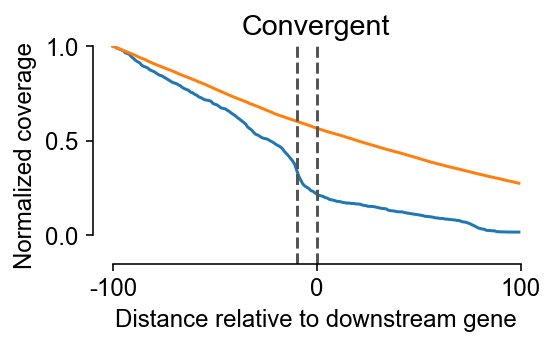

In [702]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

plt.figure(figsize=(4, 2))

gene_list = set(diff_strand_distance.query('distance > 0')['gene_id'])
col_cov, col_n = get_bam_meta_result(infile, gene_list, site_type='tRNA', threads=2)
plt.plot(col_cov/col_n, label='tRNA\ndownstream')

gene_list = set(diff_strand_distance.query('distance > 0')['gene_id'])
col_cov, col_n = get_bam_meta_result(infile, downstream_with_other_gene&different_strand_gene, site_type='downstream', threads=64)
plt.plot(col_cov/col_n, label='non-tRNA\ndownstream')

xticks = np.array([0, 100, 200])
plt.xticks(xticks, xticks-100)
plt.axvline(100, ls='--', color='#555555')
plt.axvline(90, ls='--', color='#555555')

plt.yticks([0, .5, 1.0])
plt.ylim([-.15, 1])

# plt.legend(frameon=False)
plt.xlabel('Distance relative to downstream gene')
plt.ylabel('Normalized coverage')
plt.title('Convergent')

sns.despine(top=True, right=True, trim=True)